In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import v2

In [3]:
!git clone "https://github.com/Bhavnoor-Coders-1010/DeepFakeBCS" deepfake

class DataDeepFake(Dataset):
    def __init__(self):
        self.fakeImagesLocation = "./deepfake/faketrain/"
        self.realImagesLocation = "./deepfake/realtrain/"
        self.fake = os.listdir(self.fakeImagesLocation)
        self.real = os.listdir(self.realImagesLocation)
        self.t0 = v2.Resize((224,224))
        self.t1 = v2.RandomHorizontalFlip(p=0.5)
        self.t2 = v2.RandomVerticalFlip(p=0.5)
        self.t3 = v2.RandomAffine(degrees=(-30, 30), shear=(0.75, 1.25, 0.75, 1.25))
        self.t4 = v2.ColorJitter(brightness=(0.75, 1.25), contrast=0, saturation=0, hue=0)
        self.tFinal = v2.Compose([self.t1, self.t2, self.t3, self.t4, self.t0])
        pass
    def __len__(self):
        return len(self.fake) + len(self.real)
    def __getitem__(self, idx):
        if(idx>=len(self.fake)+(len(self.real)//2)):
            img = cv2.imread(self.realImagesLocation+self.real[idx%len(self.fake)])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = np.swapaxes(img, 0,2)
            img = torch.Tensor(img)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        elif(idx>=len(self.fake)):
            img = cv2.imread(self.realImagesLocation+self.real[idx%len(self.fake)])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = np.swapaxes(img, 0,2)
            return torch.Tensor(img), torch.Tensor([0])
        elif(idx>=len(self.fake)//2):
            img = cv2.imread(self.fakeImagesLocation+self.fake[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = np.swapaxes(img, 0,2)
            img = torch.Tensor(img)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        else:
            img = cv2.imread(self.fakeImagesLocation+self.fake[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = np.swapaxes(img, 0,2)
            return torch.Tensor(img), torch.Tensor([1])
dataset = DataDeepFake()

In [4]:

# Split metadata into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)


# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [28]:
class DeepfakeNet(nn.Module):
    def __init__(self):
        super(DeepfakeNet, self).__init__()
#         self.drp = nn.Dropout(0.4)#------------------------------------------------------------------------------------------------------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers = nn.ModuleList([Bottleneck(64, 256, first=True)])
        self.out_size = [256,512,1024,2048]
        self.blocks = [1,2,2,1]
        for i in range(len(self.out_size)):
            if i > 0:
                self.layers.append(Bottleneck(self.out_size[i-1], self.out_size[i], 2))
            for extraLayers in range(self.blocks[i]-1):
                self.layers.append(Bottleneck(self.out_size[i], self.out_size[i]))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1)
        
        
        
    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):                
            layers.append(Bottleneck(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.drp(x)#------------------------------------------------------------------------------------------------------------------------------------
        x = self.conv1(x)
        x = self.maxpool(x)
        for layer in self.layers:
            x = layer(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [29]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, first=False):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels//2
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, padding=1, groups=32, stride=stride)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = stride == 2 or first 
        if self.downsample:
            self.changeInputC2D = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
            self.changeInputBn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample:
            residual = self.changeInputC2D(residual)
            residual = self.changeInputBn(residual)
        out = torch.add(out, residual)
        out = self.relu(out)
        return out



In [30]:
training_loss = []
validation_loss = []
validation_acc = []

In [31]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)
    training_loss.append(avg_loss)
    return avg_loss

In [32]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = val_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    validation_loss.append(avg_loss)
    validation_acc.append(accuracy)
    return avg_loss, accuracy

In [33]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model, optimizer, and criterion
model = DeepfakeNet()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()  # Assuming binary classification (1 output unit)

# Move model to device
model.to(device)
num_epochs = 100


In [34]:
!pip install torchsummary
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 128, 56, 56]           8,320
       BatchNorm2d-4          [-1, 128, 56, 56]             256
              ReLU-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           4,736
       BatchNorm2d-7          [-1, 128, 56, 56]             256
              ReLU-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]          33,024
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
       Bottleneck-14          [-1, 256,

In [35]:

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")


# Optionally, save your model
# torch.save(model.state_dict(), 'model.pth')

Epoch 1/100


Training Loss: 0.1124 | Validation Loss: 0.1018 | Validation Accuracy: 84.00%
Epoch 2/100


Training Loss: 0.0943 | Validation Loss: 0.1018 | Validation Accuracy: 85.36%
Epoch 3/100


Training Loss: 0.0824 | Validation Loss: 0.0943 | Validation Accuracy: 87.32%
Epoch 4/100


Training Loss: 0.0729 | Validation Loss: 0.1009 | Validation Accuracy: 84.71%
Epoch 5/100


Training Loss: 0.0620 | Validation Loss: 0.0944 | Validation Accuracy: 86.59%
Epoch 6/100


Training Loss: 0.0561 | Validation Loss: 0.0820 | Validation Accuracy: 88.70%
Epoch 7/100


Training Loss: 0.0459 | Validation Loss: 0.0858 | Validation Accuracy: 87.90%
Epoch 8/100


Training Loss: 0.0414 | Validation Loss: 0.1243 | Validation Accuracy: 84.15%
Epoch 9/100


Training Loss: 0.0356 | Validation Loss: 0.0809 | Validation Accuracy: 88.80%
Epoch 10/100


Training Loss: 0.0315 | Validation Loss: 0.0929 | Validation Accuracy: 87.59%
Epoch 11/100


Training Loss: 0.0299 | Validation Loss: 0.1857 | Validation Accuracy: 77.88%
Epoch 12/100


Training Loss: 0.0274 | Validation Loss: 0.0805 | Validation Accuracy: 88.80%
Epoch 13/100


Training Loss: 0.0237 | Validation Loss: 0.0808 | Validation Accuracy: 89.15%
Epoch 14/100


Training Loss: 0.0222 | Validation Loss: 0.0994 | Validation Accuracy: 87.27%
Epoch 15/100


Training Loss: 0.0203 | Validation Loss: 0.0878 | Validation Accuracy: 87.90%
Epoch 16/100


Training Loss: 0.0208 | Validation Loss: 0.0851 | Validation Accuracy: 88.10%
Epoch 17/100


Training Loss: 0.0180 | Validation Loss: 0.0824 | Validation Accuracy: 88.25%
Epoch 18/100


Training Loss: 0.0165 | Validation Loss: 0.0909 | Validation Accuracy: 87.49%
Epoch 19/100


Training Loss: 0.0168 | Validation Loss: 0.1023 | Validation Accuracy: 86.87%
Epoch 20/100


Training Loss: 0.0159 | Validation Loss: 0.0784 | Validation Accuracy: 89.08%
Epoch 21/100


Training Loss: 0.0155 | Validation Loss: 0.1059 | Validation Accuracy: 86.09%
Epoch 22/100


Training Loss: 0.0144 | Validation Loss: 0.0860 | Validation Accuracy: 88.80%
Epoch 23/100


Training Loss: 0.0147 | Validation Loss: 0.0815 | Validation Accuracy: 88.27%
Epoch 24/100


Training Loss: 0.0143 | Validation Loss: 0.1117 | Validation Accuracy: 85.23%
Epoch 25/100


Training Loss: 0.0138 | Validation Loss: 0.0820 | Validation Accuracy: 89.38%
Epoch 26/100


Training Loss: 0.0126 | Validation Loss: 0.0777 | Validation Accuracy: 89.05%
Epoch 27/100


Training Loss: 0.0127 | Validation Loss: 0.0999 | Validation Accuracy: 86.97%
Epoch 28/100


Training Loss: 0.0134 | Validation Loss: 0.0789 | Validation Accuracy: 88.57%
Epoch 29/100


Training Loss: 0.0120 | Validation Loss: 0.0929 | Validation Accuracy: 88.00%
Epoch 30/100


Training Loss: 0.0122 | Validation Loss: 0.0817 | Validation Accuracy: 88.05%
Epoch 31/100


Training Loss: 0.0113 | Validation Loss: 0.0838 | Validation Accuracy: 87.69%
Epoch 32/100


Training Loss: 0.0105 | Validation Loss: 0.0792 | Validation Accuracy: 89.18%
Epoch 33/100


Training Loss: 0.0106 | Validation Loss: 0.0757 | Validation Accuracy: 89.25%
Epoch 34/100


Training Loss: 0.0110 | Validation Loss: 0.0752 | Validation Accuracy: 89.43%
Epoch 35/100


Training Loss: 0.0097 | Validation Loss: 0.0874 | Validation Accuracy: 88.35%
Epoch 36/100


Training Loss: 0.0099 | Validation Loss: 0.0857 | Validation Accuracy: 88.20%
Epoch 37/100


Training Loss: 0.0097 | Validation Loss: 0.0739 | Validation Accuracy: 90.11%
Epoch 38/100


Training Loss: 0.0092 | Validation Loss: 0.0762 | Validation Accuracy: 90.11%
Epoch 39/100


Training Loss: 0.0094 | Validation Loss: 0.0754 | Validation Accuracy: 88.93%
Epoch 40/100


Training Loss: 0.0090 | Validation Loss: 0.0735 | Validation Accuracy: 89.50%
Epoch 41/100


Training Loss: 0.0089 | Validation Loss: 0.0731 | Validation Accuracy: 89.88%
Epoch 42/100


Training Loss: 0.0088 | Validation Loss: 0.0738 | Validation Accuracy: 89.93%
Epoch 43/100


Training Loss: 0.0088 | Validation Loss: 0.0754 | Validation Accuracy: 89.98%
Epoch 44/100


Training Loss: 0.0085 | Validation Loss: 0.0740 | Validation Accuracy: 90.01%
Epoch 45/100


Training Loss: 0.0079 | Validation Loss: 0.0764 | Validation Accuracy: 88.98%
Epoch 46/100


Training Loss: 0.0081 | Validation Loss: 0.0847 | Validation Accuracy: 88.80%
Epoch 47/100


Training Loss: 0.0071 | Validation Loss: 0.0749 | Validation Accuracy: 90.28%
Epoch 48/100


Training Loss: 0.0074 | Validation Loss: 0.0723 | Validation Accuracy: 89.68%
Epoch 49/100


Training Loss: 0.0076 | Validation Loss: 0.0726 | Validation Accuracy: 89.78%
Epoch 50/100


Training Loss: 0.0072 | Validation Loss: 0.0722 | Validation Accuracy: 90.13%
Epoch 51/100


Training Loss: 0.0068 | Validation Loss: 0.0749 | Validation Accuracy: 89.73%
Epoch 52/100


Training Loss: 0.0074 | Validation Loss: 0.0784 | Validation Accuracy: 88.65%
Epoch 53/100


Training Loss: 0.0074 | Validation Loss: 0.0700 | Validation Accuracy: 90.38%
Epoch 54/100


Training Loss: 0.0064 | Validation Loss: 0.0724 | Validation Accuracy: 90.38%
Epoch 55/100


Training Loss: 0.0064 | Validation Loss: 0.0926 | Validation Accuracy: 87.22%
Epoch 56/100


Training Loss: 0.0072 | Validation Loss: 0.0729 | Validation Accuracy: 90.38%
Epoch 57/100


Training Loss: 0.0066 | Validation Loss: 0.0718 | Validation Accuracy: 90.38%
Epoch 58/100


Training Loss: 0.0059 | Validation Loss: 0.0693 | Validation Accuracy: 90.36%
Epoch 59/100


Training Loss: 0.0053 | Validation Loss: 0.0756 | Validation Accuracy: 89.20%
Epoch 60/100


Training Loss: 0.0055 | Validation Loss: 0.0699 | Validation Accuracy: 90.23%
Epoch 61/100


Training Loss: 0.0067 | Validation Loss: 0.0749 | Validation Accuracy: 89.15%
Epoch 62/100


Training Loss: 0.0051 | Validation Loss: 0.0697 | Validation Accuracy: 90.38%
Epoch 63/100


Training Loss: 0.0048 | Validation Loss: 0.0725 | Validation Accuracy: 90.06%
Epoch 64/100


Training Loss: 0.0052 | Validation Loss: 0.0713 | Validation Accuracy: 90.03%
Epoch 65/100


Training Loss: 0.0051 | Validation Loss: 0.0694 | Validation Accuracy: 90.13%
Epoch 66/100


Training Loss: 0.0056 | Validation Loss: 0.0685 | Validation Accuracy: 90.48%
Epoch 67/100


Training Loss: 0.0052 | Validation Loss: 0.0688 | Validation Accuracy: 90.38%
Epoch 68/100


Training Loss: 0.0054 | Validation Loss: 0.0691 | Validation Accuracy: 90.41%
Epoch 69/100


Training Loss: 0.0048 | Validation Loss: 0.0692 | Validation Accuracy: 90.48%
Epoch 70/100


Training Loss: 0.0047 | Validation Loss: 0.0846 | Validation Accuracy: 87.80%
Epoch 71/100


Training Loss: 0.0047 | Validation Loss: 0.0739 | Validation Accuracy: 89.85%
Epoch 72/100


Training Loss: 0.0047 | Validation Loss: 0.0680 | Validation Accuracy: 90.63%
Epoch 73/100


Training Loss: 0.0046 | Validation Loss: 0.0691 | Validation Accuracy: 90.66%
Epoch 74/100


Training Loss: 0.0044 | Validation Loss: 0.0695 | Validation Accuracy: 90.58%
Epoch 75/100


Training Loss: 0.0047 | Validation Loss: 0.0683 | Validation Accuracy: 90.36%
Epoch 76/100


Training Loss: 0.0042 | Validation Loss: 0.0794 | Validation Accuracy: 89.40%
Epoch 77/100


Training Loss: 0.0043 | Validation Loss: 0.0685 | Validation Accuracy: 90.71%
Epoch 78/100


Training Loss: 0.0043 | Validation Loss: 0.0745 | Validation Accuracy: 89.53%
Epoch 79/100


Training Loss: 0.0043 | Validation Loss: 0.0674 | Validation Accuracy: 91.01%
Epoch 80/100


Training Loss: 0.0042 | Validation Loss: 0.0671 | Validation Accuracy: 91.26%
Epoch 81/100


Training Loss: 0.0040 | Validation Loss: 0.0672 | Validation Accuracy: 90.46%
Epoch 82/100


Training Loss: 0.0039 | Validation Loss: 0.0676 | Validation Accuracy: 90.73%
Epoch 83/100


Training Loss: 0.0037 | Validation Loss: 0.0719 | Validation Accuracy: 90.41%
Epoch 84/100


Training Loss: 0.0041 | Validation Loss: 0.0700 | Validation Accuracy: 90.46%
Epoch 85/100


Training Loss: 0.0041 | Validation Loss: 0.0688 | Validation Accuracy: 90.66%
Epoch 86/100


Training Loss: 0.0037 | Validation Loss: 0.0694 | Validation Accuracy: 90.41%
Epoch 87/100


Training Loss: 0.0034 | Validation Loss: 0.0667 | Validation Accuracy: 91.03%
Epoch 88/100


Training Loss: 0.0035 | Validation Loss: 0.0683 | Validation Accuracy: 90.61%
Epoch 89/100


Training Loss: 0.0039 | Validation Loss: 0.0694 | Validation Accuracy: 90.48%
Epoch 90/100


Training Loss: 0.0034 | Validation Loss: 0.0695 | Validation Accuracy: 90.66%
Epoch 91/100


Training Loss: 0.0036 | Validation Loss: 0.0713 | Validation Accuracy: 90.36%
Epoch 92/100


Training Loss: 0.0036 | Validation Loss: 0.0663 | Validation Accuracy: 91.03%
Epoch 93/100


Training Loss: 0.0035 | Validation Loss: 0.0717 | Validation Accuracy: 89.85%
Epoch 94/100


Training Loss: 0.0032 | Validation Loss: 0.0697 | Validation Accuracy: 90.31%
Epoch 95/100


Training Loss: 0.0032 | Validation Loss: 0.0663 | Validation Accuracy: 91.03%
Epoch 96/100


Training Loss: 0.0035 | Validation Loss: 0.0671 | Validation Accuracy: 91.06%
Epoch 97/100


Training Loss: 0.0033 | Validation Loss: 0.0664 | Validation Accuracy: 91.31%
Epoch 98/100


Training Loss: 0.0031 | Validation Loss: 0.0660 | Validation Accuracy: 91.14%
Epoch 99/100


Training Loss: 0.0030 | Validation Loss: 0.0656 | Validation Accuracy: 91.19%
Epoch 100/100


Training Loss: 0.0030 | Validation Loss: 0.0662 | Validation Accuracy: 90.93%


In [38]:
epochs = list(range(1,num_epochs+1))

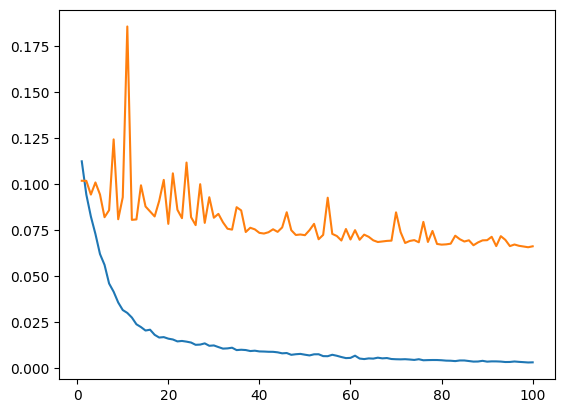

In [39]:
plt.plot(epochs, training_loss)
plt.plot(epochs, validation_loss)

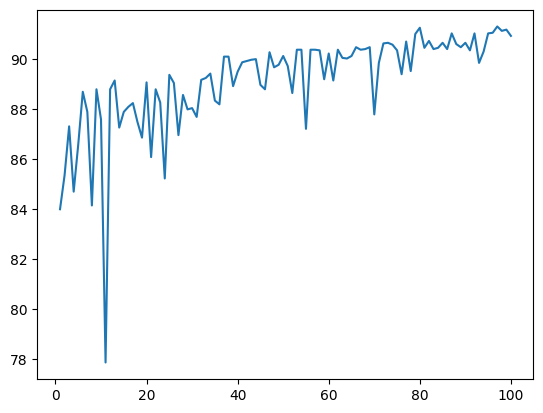

In [40]:
plt.plot(epochs, validation_acc)

In [41]:
torch.save(model.state_dict(), '/kaggle/working/DeepFakeBCS.pth')